# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu) #, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu) #, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu) #, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-4
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: preprocess.x_test, 
                                                                 net.y_: preprocess.y_test, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))

            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual, net.y], 
                                                          feed_dict={net.x: preprocess.x_test, 
                                                                     net.y_: preprocess.y_test, 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            
            curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
            Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
            
            if accuracy > Train.best_acc:
                Train.best_acc = accuracy
                Train.pred_value = pred_value
                Train.actual_value = actual_value
                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                #net.saver.save(sess, "dataset/epochs_{}_hidden layers_{}_features count_{}".format(epochs,h,f))
            Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 32, 64]
    hidden_layers_arr = [4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:4 features count:4
Step 1 | Training Loss: 0.528424 | Validation Accuracy: 0.574831
Step 2 | Training Loss: 0.509805 | Validation Accuracy: 0.713582
Step 3 | Training Loss: 0.483057 | Validation Accuracy: 0.724051
Step 4 | Training Loss: 0.488333 | Validation Accuracy: 0.734608
Step 5 | Training Loss: 0.472584 | Validation Accuracy: 0.752706
Step 6 | Training Loss: 0.470036 | Validation Accuracy: 0.753903
Step 7 | Training Loss: 0.448185 | Validation Accuracy: 0.754702
Step 8 | Training Loss: 0.456574 | Validation Accuracy: 0.759138
Step 9 | Training Loss: 0.446128 | Validation Accuracy: 0.768054
Step 10 | Training Loss: 0.424114 | Validation Accuracy: 0.773066
Step 11 | Training Loss: 0.413871 | Validation Accuracy: 0.781627
Step 12 | Training Loss: 0.340858 | Validation Accuracy: 0.790055
Step 13 | Training Loss: 0.324988 | Validation Accuracy: 0.778256
Step 14 | Training Loss: 0.340924 | Validation Accuracy: 0.767433
Step 15 | Trai

Step 23 | Training Loss: 0.324293 | Validation Accuracy: 0.786817
Step 24 | Training Loss: 0.338261 | Validation Accuracy: 0.787482
Step 25 | Training Loss: 0.332444 | Validation Accuracy: 0.786595
Step 26 | Training Loss: 0.325635 | Validation Accuracy: 0.786684
Step 27 | Training Loss: 0.324902 | Validation Accuracy: 0.787127
Step 28 | Training Loss: 0.322234 | Validation Accuracy: 0.786728
Step 29 | Training Loss: 0.325591 | Validation Accuracy: 0.786595
Step 30 | Training Loss: 0.324101 | Validation Accuracy: 0.786595
Step 31 | Training Loss: 0.321616 | Validation Accuracy: 0.786595
Step 32 | Training Loss: 0.320471 | Validation Accuracy: 0.785397
Step 33 | Training Loss: 0.328288 | Validation Accuracy: 0.784643
Step 34 | Training Loss: 0.331906 | Validation Accuracy: 0.785531
Step 35 | Training Loss: 0.324096 | Validation Accuracy: 0.785176
Step 36 | Training Loss: 0.323658 | Validation Accuracy: 0.784688
Step 37 | Training Loss: 0.321389 | Validation Accuracy: 0.783534
Step 38 | 

Step 46 | Training Loss: 0.327553 | Validation Accuracy: 0.763263
Step 47 | Training Loss: 0.329097 | Validation Accuracy: 0.766279
Step 48 | Training Loss: 0.326059 | Validation Accuracy: 0.769384
Step 49 | Training Loss: 0.326215 | Validation Accuracy: 0.770005
Step 50 | Training Loss: 0.322354 | Validation Accuracy: 0.764771
Step 51 | Training Loss: 0.322948 | Validation Accuracy: 0.764904
Step 52 | Training Loss: 0.320776 | Validation Accuracy: 0.766945
Step 53 | Training Loss: 0.319091 | Validation Accuracy: 0.765836
Step 54 | Training Loss: 0.326438 | Validation Accuracy: 0.768231
Step 55 | Training Loss: 0.330119 | Validation Accuracy: 0.770804
Step 56 | Training Loss: 0.321621 | Validation Accuracy: 0.764815
Step 57 | Training Loss: 0.322082 | Validation Accuracy: 0.766279
Step 58 | Training Loss: 0.325788 | Validation Accuracy: 0.767654
Step 59 | Training Loss: 0.323731 | Validation Accuracy: 0.771070
Step 60 | Training Loss: 0.324359 | Validation Accuracy: 0.765924
Step 61 | 

Step 69 | Training Loss: 0.324984 | Validation Accuracy: 0.773998
Step 70 | Training Loss: 0.324201 | Validation Accuracy: 0.775683
Step 71 | Training Loss: 0.316926 | Validation Accuracy: 0.776659
Step 72 | Training Loss: 0.324930 | Validation Accuracy: 0.774619
Step 73 | Training Loss: 0.325752 | Validation Accuracy: 0.774042
Step 74 | Training Loss: 0.324356 | Validation Accuracy: 0.782115
Step 75 | Training Loss: 0.318600 | Validation Accuracy: 0.776615
Step 76 | Training Loss: 0.323614 | Validation Accuracy: 0.779897
Step 77 | Training Loss: 0.325645 | Validation Accuracy: 0.779498
Step 78 | Training Loss: 0.319134 | Validation Accuracy: 0.779587
Step 79 | Training Loss: 0.320403 | Validation Accuracy: 0.778522
Step 80 | Training Loss: 0.327434 | Validation Accuracy: 0.779941
Step 81 | Training Loss: 0.327335 | Validation Accuracy: 0.779187
Step 82 | Training Loss: 0.329323 | Validation Accuracy: 0.779720
Step 83 | Training Loss: 0.318584 | Validation Accuracy: 0.777591
Step 84 | 

Step 92 | Training Loss: 0.333496 | Validation Accuracy: 0.776925
Step 93 | Training Loss: 0.324076 | Validation Accuracy: 0.777103
Step 94 | Training Loss: 0.325730 | Validation Accuracy: 0.777635
Step 95 | Training Loss: 0.320513 | Validation Accuracy: 0.777768
Step 96 | Training Loss: 0.334719 | Validation Accuracy: 0.777103
Step 97 | Training Loss: 0.324064 | Validation Accuracy: 0.777457
Step 98 | Training Loss: 0.334592 | Validation Accuracy: 0.778167
Step 99 | Training Loss: 0.325685 | Validation Accuracy: 0.777546
Step 100 | Training Loss: 0.329460 | Validation Accuracy: 0.777280
Accuracy on Test data: 0.7772799730300903
Current Layer Attributes - epochs:100 hidden layers:6 features count:8
Step 1 | Training Loss: 0.533019 | Validation Accuracy: 0.897489
Step 2 | Training Loss: 0.512365 | Validation Accuracy: 0.797596
Step 3 | Training Loss: 0.483961 | Validation Accuracy: 0.780784
Step 4 | Training Loss: 0.472232 | Validation Accuracy: 0.769340
Step 5 | Training Loss: 0.438500

Step 13 | Training Loss: 0.332453 | Validation Accuracy: 0.751464
Step 14 | Training Loss: 0.332685 | Validation Accuracy: 0.754258
Step 15 | Training Loss: 0.332550 | Validation Accuracy: 0.754391
Step 16 | Training Loss: 0.326513 | Validation Accuracy: 0.753105
Step 17 | Training Loss: 0.328566 | Validation Accuracy: 0.751863
Step 18 | Training Loss: 0.331710 | Validation Accuracy: 0.750266
Step 19 | Training Loss: 0.330521 | Validation Accuracy: 0.751508
Step 20 | Training Loss: 0.328630 | Validation Accuracy: 0.750754
Step 21 | Training Loss: 0.333067 | Validation Accuracy: 0.751153
Step 22 | Training Loss: 0.325796 | Validation Accuracy: 0.752351
Step 23 | Training Loss: 0.334373 | Validation Accuracy: 0.751242
Step 24 | Training Loss: 0.322312 | Validation Accuracy: 0.750843
Step 25 | Training Loss: 0.331492 | Validation Accuracy: 0.752617
Step 26 | Training Loss: 0.322334 | Validation Accuracy: 0.751996
Step 27 | Training Loss: 0.325306 | Validation Accuracy: 0.751819
Step 28 | 

Step 36 | Training Loss: 0.318737 | Validation Accuracy: 0.768408
Step 37 | Training Loss: 0.323644 | Validation Accuracy: 0.764860
Step 38 | Training Loss: 0.326714 | Validation Accuracy: 0.767832
Step 39 | Training Loss: 0.323866 | Validation Accuracy: 0.762731
Step 40 | Training Loss: 0.318597 | Validation Accuracy: 0.767876
Step 41 | Training Loss: 0.320391 | Validation Accuracy: 0.768985
Step 42 | Training Loss: 0.322098 | Validation Accuracy: 0.769429
Step 43 | Training Loss: 0.318774 | Validation Accuracy: 0.769473
Step 44 | Training Loss: 0.323888 | Validation Accuracy: 0.769562
Step 45 | Training Loss: 0.318554 | Validation Accuracy: 0.766945
Step 46 | Training Loss: 0.319191 | Validation Accuracy: 0.764372
Step 47 | Training Loss: 0.325632 | Validation Accuracy: 0.769828
Step 48 | Training Loss: 0.315972 | Validation Accuracy: 0.768275
Step 49 | Training Loss: 0.323896 | Validation Accuracy: 0.764949
Step 50 | Training Loss: 0.324402 | Validation Accuracy: 0.773643
Step 51 | 

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
1,100,8,4,0.788369,0.788369
0,100,4,4,0.779808,0.779808
3,100,64,4,0.778167,0.778167
4,100,4,6,0.777280,0.777280
7,100,64,6,0.770538,0.770538
2,100,32,4,0.767211,0.767211
5,100,8,6,0.763263,0.763263
6,100,32,6,0.750000,0.750000


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.6823  0.3177]
 [ 0.0715  0.9285]]


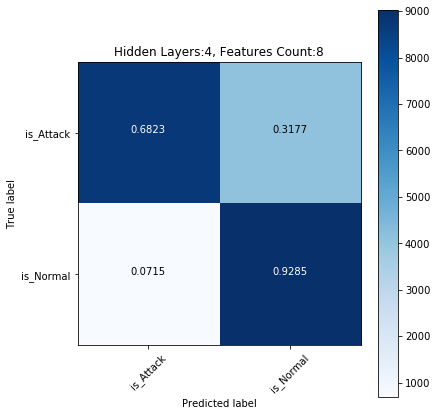

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)